<a href="https://colab.research.google.com/github/jfink09/optical-funduscopic-convolutional-neural-network/blob/main/Model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu116
torchvision version: 0.14.0+cu116


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/jfink09/optical-funduscopic-convolutional-neural-network
    !mv optical-funduscopic-convolutional-neural-network/going_modular .
    !mv optical-funduscopic-convolutional-neural-network/helper_functions.py . # get the helper_functions.py script
    !rm -rf optical-funduscopic-convolutional-neural-network
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'optical-funduscopic-convolutional-neural-network'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 240 (delta 79), reused 90 (delta 40), pack-reused 72
Receiving objects: 100% (240/240), 110.78 MiB | 22.11 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_path = download_data(source="https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/data/drappcompressed.zip",
                                     destination="fundus images")

data_path

[INFO] Did not find data/fundus images directory, creating one...
[INFO] Downloading drappcompressed.zip from https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/data/drappcompressed.zip...
[INFO] Unzipping drappcompressed.zip data...


PosixPath('data/fundus images')

In [5]:
# Setup directory paths to train and test images
train_dir = data_path / "train"
test_dir = data_path / "test"

In [6]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [7]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=2)) # change out_features to suit our number of classes

In [9]:
def create_effnetb2_model(num_classes:int=2, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=2,
                                                      seed=42)

In [11]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 2]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [12]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [13]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6068 | train_acc: 0.7739 | test_loss: 0.5070 | test_acc: 0.7656
Epoch: 2 | train_loss: 0.4741 | train_acc: 0.8478 | test_loss: 0.3513 | test_acc: 0.8594
Epoch: 3 | train_loss: 0.3138 | train_acc: 0.9812 | test_loss: 0.2366 | test_acc: 0.9844
Epoch: 4 | train_loss: 0.2596 | train_acc: 0.9625 | test_loss: 0.1584 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.1900 | train_acc: 0.9812 | test_loss: 0.1155 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.1724 | train_acc: 0.9812 | test_loss: 0.0902 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.1501 | train_acc: 0.9688 | test_loss: 0.0720 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.1190 | train_acc: 1.0000 | test_loss: 0.0611 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.1121 | train_acc: 0.9875 | test_loss: 0.0536 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.1074 | train_acc: 0.9875 | test_loss: 0.0469 | test_acc: 1.0000


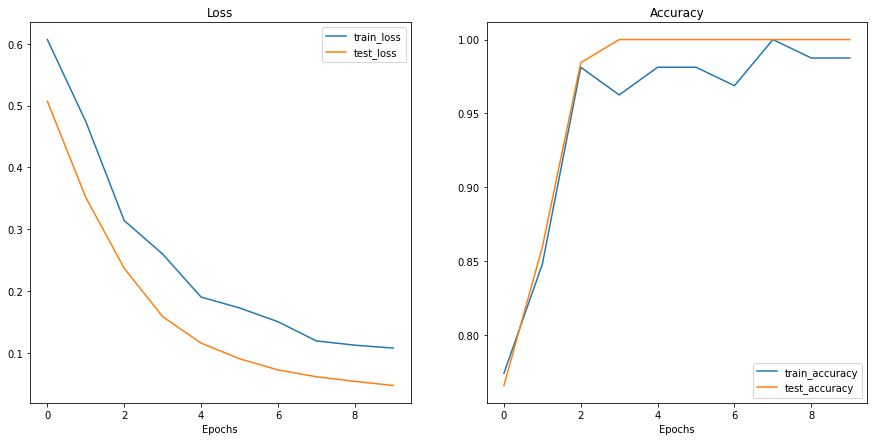

In [14]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [15]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_drappcompressed.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_drappcompressed.pth


In [16]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor_drappcompressed.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [17]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7703812

In [18]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.04685280006378889,
 'test_acc': 1.0,
 'number_of_parameters': 7703812,
 'model_size (MB)': 29}

In [19]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [20]:
def create_vit_model(num_classes:int=2, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [21]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=2,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [22]:
from torchinfo import summary

# Print ViT feature extractor model summary (uncomment for full output)
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 2]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [23]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [24]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7115 | train_acc: 0.5266 | test_loss: 0.3990 | test_acc: 0.9844
Epoch: 2 | train_loss: 0.4322 | train_acc: 0.8625 | test_loss: 0.2881 | test_acc: 0.9844
Epoch: 3 | train_loss: 0.2848 | train_acc: 0.9264 | test_loss: 0.1633 | test_acc: 0.9844
Epoch: 4 | train_loss: 0.2140 | train_acc: 0.9264 | test_loss: 0.1246 | test_acc: 0.9844
Epoch: 5 | train_loss: 0.1650 | train_acc: 0.9437 | test_loss: 0.1158 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.1382 | train_acc: 0.9812 | test_loss: 0.0967 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.1153 | train_acc: 0.9875 | test_loss: 0.0714 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.1052 | train_acc: 0.9851 | test_loss: 0.0582 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0911 | train_acc: 0.9875 | test_loss: 0.0561 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0815 | train_acc: 0.9875 | test_loss: 0.0559 | test_acc: 1.0000


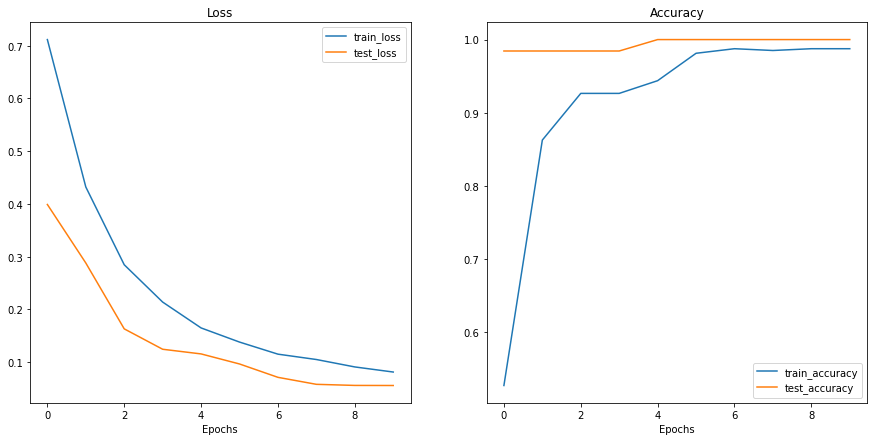

In [25]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [26]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_drappcompressed.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_drappcompressed.pth


In [27]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_drappcompressed.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [28]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800194

In [29]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.05594227276742458,
 'test_acc': 1.0,
 'number_of_parameters': 85800194,
 'model_size (MB)': 327}

In [30]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/fundus images/test


[PosixPath('data/fundus images/test/dr/dr71.jpg'),
 PosixPath('data/fundus images/test/dr/dr87.jpg'),
 PosixPath('data/fundus images/test/dr/dr76.jpg'),
 PosixPath('data/fundus images/test/dr/dr78.jpg'),
 PosixPath('data/fundus images/test/dr/dr77.jpg')]

In [31]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

In [32]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

  0%|          | 0/38 [00:00<?, ?it/s]

In [33]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/fundus images/test/dr/dr71.jpg'),
  'class_name': 'dr',
  'pred_prob': 0.9522,
  'pred_class': 'dr',
  'time_for_pred': 0.607,
  'correct': True},
 {'image_path': PosixPath('data/fundus images/test/dr/dr87.jpg'),
  'class_name': 'dr',
  'pred_prob': 0.8624,
  'pred_class': 'dr',
  'time_for_pred': 0.2935,
  'correct': True}]

In [34]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/fundus images/test/dr/dr71.jpg,dr,0.9522,dr,0.6070,True
1,data/fundus images/test/dr/dr87.jpg,dr,0.8624,dr,0.2935,True
2,data/fundus images/test/dr/dr76.jpg,dr,0.9227,dr,0.4375,True
3,data/fundus images/test/dr/dr78.jpg,dr,0.9411,dr,0.2289,True
4,data/fundus images/test/dr/dr77.jpg,dr,0.9170,dr,0.3012,True


In [35]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True    38
Name: correct, dtype: int64

In [36]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.2803 seconds


In [37]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.04685280006378889,
 'test_acc': 1.0,
 'number_of_parameters': 7703812,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.2803}

In [38]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/38 [00:00<?, ?it/s]

In [39]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/fundus images/test/dr/dr71.jpg'),
  'class_name': 'dr',
  'pred_prob': 0.9762,
  'pred_class': 'dr',
  'time_for_pred': 1.7372,
  'correct': True},
 {'image_path': PosixPath('data/fundus images/test/dr/dr87.jpg'),
  'class_name': 'dr',
  'pred_prob': 0.9957,
  'pred_class': 'dr',
  'time_for_pred': 1.5545,
  'correct': True}]

In [40]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/fundus images/test/dr/dr71.jpg,dr,0.9762,dr,1.7372,True
1,data/fundus images/test/dr/dr87.jpg,dr,0.9957,dr,1.5545,True
2,data/fundus images/test/dr/dr76.jpg,dr,0.9945,dr,1.5590,True
3,data/fundus images/test/dr/dr78.jpg,dr,0.9593,dr,1.4848,True
4,data/fundus images/test/dr/dr77.jpg,dr,0.9997,dr,1.7639,True


In [41]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True    38
Name: correct, dtype: int64

In [42]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True    38
Name: correct, dtype: int64

In [43]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 1.5692 seconds


In [44]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.05594227276742458,
 'test_acc': 1.0,
 'number_of_parameters': 85800194,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 1.5692}

In [45]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.05594227276742458,
 'test_acc': 1.0,
 'number_of_parameters': 85800194,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 1.5692}

In [46]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.046853,100.0,7703812,29,0.2803,EffNetB2
1,0.055942,100.0,85800194,327,1.5692,ViT


In [47]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,1.194001,1.0,11.137369,11.275862,5.598288


In [50]:
!pip install matplotlib==3.3.0
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.5 MB 34.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


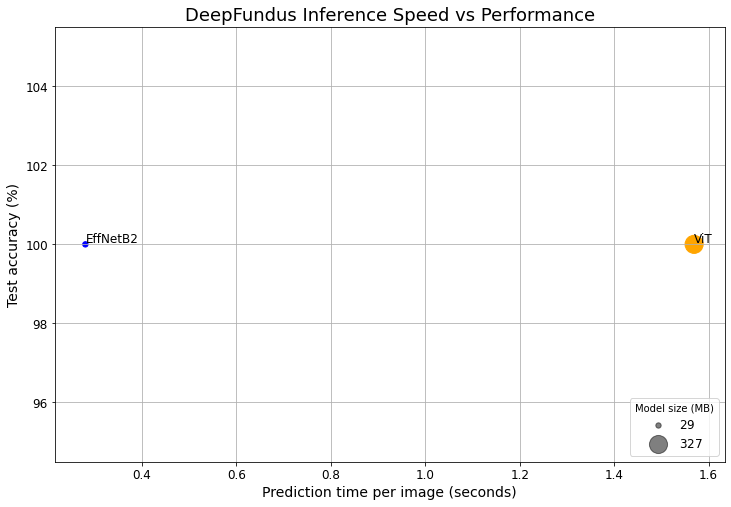

In [64]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("DeepFundus Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
  # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
    ax.annotate(s=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("models/deep-fundus-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

In [65]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

     |████████████████████████████████| 13.8 MB 36.6 MB/s 
     |████████████████████████████████| 106 kB 69.1 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 84 kB 3.3 MB/s 
     |████████████████████████████████| 2.3 MB 61.4 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 213 kB 90.5 MB/s 
     |████████████████████████████████| 84 kB 4.8 MB/s 
     |████████████████████████████████| 278 kB 53.5 MB/s 
     |████████████████████████████████| 64 kB 3.5 MB/s 
     |████████████████████████████████| 80 kB 9.7 MB/s 
     |████████████████████████████████| 68 kB 8.3 MB/s 
     |████████████████████████████████| 68 kB 8.1 MB/s 
     |████████████████████████████████| 68 kB 8.0 MB/s 
     |████████████████████████████████| 68 kB 7.1 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |███████████████████████████████

In [66]:
# Put EffNetB2 on CPU
effnetb2.to("cpu") 

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [67]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [68]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/fundus images/test/normal/normal85.jpg

Prediction label and probability dictionary: 
{'dr': 0.23632021248340607, 'normal': 0.7636797428131104}
Prediction time: 0.50246 seconds


In [69]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/fundus images/test/normal/normal89.jpg'],
 ['data/fundus images/test/normal/normal91.jpg'],
 ['data/fundus images/test/normal/normal88.jpg']]

In [70]:
import gradio as gr

# Create title, description and article strings
title = "DeepFundus 👀"
description = "An EfficientNetB2 feature extractor computer vision model to classify normal and diabetic retinopathy optical funduscopic images."
article = "Created for fun."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://490447d13af4e6fb.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [71]:
import shutil
from pathlib import Path

# Create DeepFundus demo path
deepfundus_demo_path = Path("demos/DeepFunuds/")

# Remove files that might already exist there and create new directory
if deepfundus_demo_path.exists():
    shutil.rmtree(deepfundus_demo_path)
    deepfundus_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    deepfundus_demo_path.mkdir(parents=True, 
                                    exist_ok=True)
    
# Check what's in the folder
!ls demos/deepfundus/

ls: cannot access 'demos/deepfundus/': No such file or directory


In [73]:
import shutil
from pathlib import Path

# 1. Create an examples directory
deepfundus_examples_path = deepfundus_demo_path / "examples"
deepfundus_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
deepfundus_examples = [Path('data/fundus images/test/dr/dr71.jpg'),
                            Path('data/fundus images/test/dr/dr72.jpg')]

# 3. Copy the three random images to the examples directory
for example in deepfundus_examples:
    destination = deepfundus_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/fundus images/test/dr/dr71.jpg to demos/DeepFunuds/examples/dr71.jpg
[INFO] Copying data/fundus images/test/dr/dr72.jpg to demos/DeepFunuds/examples/dr72.jpg


In [74]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(deepfundus_examples_path)]
example_list

[['examples/dr71.jpg'], ['examples/dr72.jpg']]

In [75]:
import shutil

# Create a source path for our target model
effnetb2_deepfundus_model_path = "models/pretrained_effnetb2_feature_extractor_deep_fundus.pth"

# Create a destination path for our target model 
effnetb2_deepfundus_model_destination = deepfundus_demo_path / effnetb2_deepfundus_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_deepfundus_model_path} to {effnetb2_deepfundus_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_deepfundus_model_path, 
                dst=effnetb2_deepfundus_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_deepfundus_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_deepfundus_model_destination}: {effnetb2_deepfundus_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnetb2_feature_extractor_deep_fundus.pth to demos/DeepFunuds/pretrained_effnetb2_feature_extractor_deep_fundus.pth
[INFO] No model found at models/pretrained_effnetb2_feature_extractor_deep_fundus.pth, perhaps its already been moved?
[INFO] Model exists at demos/DeepFunuds/pretrained_effnetb2_feature_extractor_deep_fundus.pth: False


In [81]:
%%writefile demos/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=2, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/model.py


In [83]:
%%writefile demos/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["normal", "dr"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=2, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_deep_fundus.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "DeepFundus 👀"
description = "An EfficientNetB2 feature extractor computer vision model to classify normal and diabetic retinopathy optical funduscopic images."
article = "Created for fun."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=2, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/app.py


In [85]:
%%writefile demos/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/requirements.txt
